# Minimize Raw Data
考虑到原始文件较大，使用pandas读取时选择合适的数据类型并压缩内存占用。本文对数据做预处理，找到数据框最合适的数据类型并重新读取，可以将内存占用压缩一半（压缩后942MB）.

本文结束时输出数据框最小数据类型到临时文件夹。

In [1]:
# improt packages
import pandas as pd
import pprint
import numpy as np
import itertools as it

import matplotlib as mpl
import matplotlib.pylab as plt
%matplotlib inline

load sample data training data

In [3]:
pp = pprint.PrettyPrinter(indent=4)

%time df_train = pd.read_csv('../data/tap_fun_train.csv', infer_datetime_format=True)
df_train.head()

FileNotFoundError: File b'data/tap_fun_train.csv' does not exist

NameError: name 'df_train' is not defined

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2288007 entries, 0 to 2288006
Columns: 109 entries, user_id to prediction_pay_price
dtypes: float64(13), int64(95), object(1)
memory usage: 1.9+ GB


In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2288007 entries, 0 to 2288006
Columns: 109 entries, user_id to prediction_pay_price
dtypes: float64(13), int64(95), object(1)
memory usage: 1.9+ GB


get minimum datatype

In [3]:
gl_int = df_train.select_dtypes(include=['int64'])

int_types = ["uint16", "uint32","uint64"]
int_types_max = {}
for it in int_types:
    int_types_max[it] = np.iinfo(it).max
int_types_max = sorted(int_types_max.items(),key= lambda x: x[1])

import itertools as it
column_types = {}
for field,max in gl_int.max().iteritems():
    best_type= list(it.filterfalse(lambda x: max>x[1],int_types_max))
    column_types[field] = best_type[0][0]


In [4]:
gl_float = df_train.select_dtypes(include=['float64'])
float_types = ["float32","float64"]
float_types_max = {}
for it in float_types:
    float_types_max[it] = np.finfo(it).max
float_types_max = sorted(float_types_max.items(),key= lambda x: x[1])

import itertools as it
for field,max in gl_float.max().iteritems():
    best_type= list(it.filterfalse(lambda x: max>x[1],float_types_max))
    column_types[field] = best_type[0][0]
column_types    

{'user_id': 'uint32',
 'infantry_add_value': 'uint32',
 'infantry_reduce_value': 'uint32',
 'cavalry_add_value': 'uint32',
 'cavalry_reduce_value': 'uint32',
 'shaman_add_value': 'uint32',
 'shaman_reduce_value': 'uint32',
 'wound_infantry_add_value': 'uint32',
 'wound_infantry_reduce_value': 'uint32',
 'wound_cavalry_add_value': 'uint32',
 'wound_cavalry_reduce_value': 'uint32',
 'wound_shaman_add_value': 'uint32',
 'wound_shaman_reduce_value': 'uint32',
 'general_acceleration_add_value': 'uint32',
 'general_acceleration_reduce_value': 'uint32',
 'building_acceleration_add_value': 'uint32',
 'building_acceleration_reduce_value': 'uint32',
 'reaserch_acceleration_add_value': 'uint32',
 'reaserch_acceleration_reduce_value': 'uint32',
 'training_acceleration_add_value': 'uint32',
 'training_acceleration_reduce_value': 'uint32',
 'treatment_acceleraion_add_value': 'uint16',
 'treatment_acceleration_reduce_value': 'uint16',
 'bd_training_hut_level': 'uint16',
 'bd_healing_lodge_level': 'ui

store column_types as intermidate file

In [5]:
import pickle
pickle.dump(column_types,open('tmp/column_types.pickle','wb'))
column_types = pickle.load(open('tmp/column_types.pickle','rb'))

In [11]:
%time df_train = pd.read_csv('data/tap_fun_train.csv',dtype=column_types, parse_dates=['register_time'], infer_datetime_format=True)

Wall time: 30.9 s


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2288007 entries, 0 to 2288006
Columns: 109 entries, user_id to prediction_pay_price
dtypes: datetime64[ns](1), float32(13), uint16(74), uint32(21)
memory usage: 637.1 MB


In [14]:
%time df_train.to_hdf('data/tap_fun_train.h5','/data')

Wall time: 5.7 s


In [8]:
%time df_test = pd.read_csv('data/tap_fun_test.csv',dtype=column_types, parse_dates=['register_time'], infer_datetime_format=True)

Wall time: 10.4 s


In [9]:
%time df_test.to_hdf('data/tap_fun_test.h5','/data')

Wall time: 2.25 s


read dask dataframe

In [5]:
import dask.dataframe as ddf

In [6]:
ddf_train =ddf.from_pandas(df_train, npartitions=8)

compare performance, pandas response faster oberviously

from_pandas perforamnce is better than pandas and read from multiple file

In [9]:
%time df_train['user_id'].max()

Wall time: 72.2 ms


3190530

In [10]:
%time ddf_train['user_id'].min().compute()

Wall time: 46 ms


1

In [ ]:
%time ddf_train.describe().compute()

Wall time: 10.7 s


,user_id,wood_add_value,wood_reduce_value,stone_add_value,stone_reduce_value,ivory_add_value,ivory_reduce_value,meat_add_value,meat_reduce_value,magic_add_value,...,pvp_battle_count,pvp_lanch_count,pvp_win_count,pve_battle_count,pve_lanch_count,pve_win_count,avg_online_minutes,pay_price,pay_count,prediction_pay_price
count,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,...,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06,2.288007e+06
mean,1.529543e+06,4.543069e+05,3.698433e+05,1.897788e+05,1.376074e+05,8.075623e+04,3.613170e+04,5.855155e+05,3.548102e+05,7.538954e+04,...,2.148313e+00,1.059639e+00,9.838589e-01,2.844738e+00,2.832409e+00,2.556749e+00,1.020749e+01,5.346691e-01,5.770699e-02,1.793146e+00
std,9.399393e+05,4.958667e+06,3.737720e+06,4.670620e+06,3.370166e+06,2.220540e+06,1.782499e+06,5.868629e+06,3.400632e+06,9.662892e+05,...,1.167797e+01,9.074459e+00,8.951280e+00,1.276245e+01,1.271820e+01,1.184737e+01,3.895946e+01,2.263835e+01,7.090886e-01,8.846303e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.230080e+05,1.000000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+04,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.787749e+06,5.410750e+04,1.661000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.200500e+04,9.444000e+03,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,3.083868e+06,1.668665e+05,1.006360e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.537720e+05,6.917500e+04,0.000000e+00,...,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,5.166667e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,3.190530e+06,1.239962e+09,7.995875e+08,1.214869e+09,7.962378e+08,5.744961e+08,4.481972e+08,1.470644e+09,8.889537e+08,2.637228e+08,...,2.054000e+03,2.051000e+03,1.904000e+03,5.090000e+02,5.090000e+02,4.880000e+02,2.049667e+03,7.457950e+03,1.050000e+02,3.297781e+04


日均注册用户数

In [7]:
df_train['register_date']=df_train.register_time.apply(lambda x:pd.to_datetime(x).strftime('%Y-%m-%d'))
agg_usercntbyday = df_train.groupby('register_date')['user_id'].count()

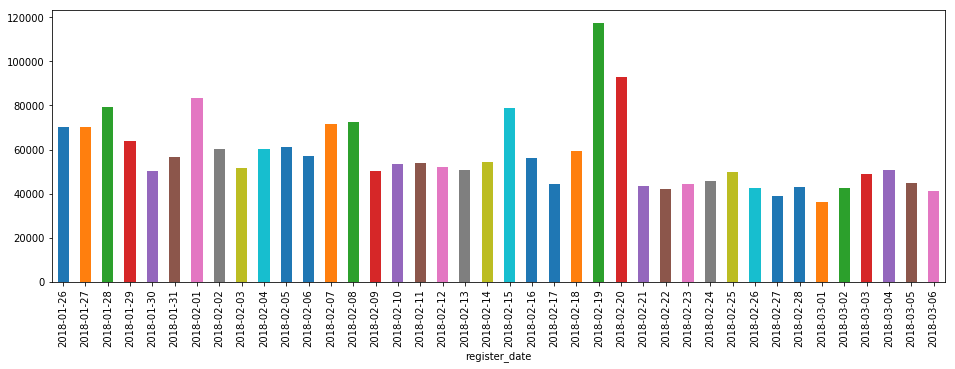

In [8]:
agg_usercntbyday.plot(kind='bar',figsize=(16,5));

付款价格频率图

In [9]:
df_train['pay_price'].describe()

count    2.288007e+06
mean     5.346689e-01
std      2.263835e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      7.457950e+03
Name: pay_price, dtype: float64

In [10]:
df_train['pay_price_group']=pd.cut( df_train['pay_price'],[0,.01,10,100,1000,10000,100000],right=False)
df_train['pay_price_group'].value_counts()

[0.0, 0.01)            2246568
[0.01, 10.0)             29094
[10.0, 100.0)            10310
[100.0, 1000.0)           1860
[1000.0, 10000.0)          175
[10000.0, 100000.0)          0
Name: pay_price_group, dtype: int64

In [11]:
df_train['prediction_future_pay_price'] = df_train['prediction_pay_price'] - df_train['pay_price']
df_train['prediction_pay_price_group']=pd.cut( df_train['prediction_pay_price'],[0,0.01,10,100,1000,10000,100000],right=False)
df_train['prediction_pay_price_group'].value_counts()

[0.0, 0.01)            2242019
[0.01, 10.0)             29286
[10.0, 100.0)            12093
[100.0, 1000.0)           3822
[1000.0, 10000.0)          758
[10000.0, 100000.0)         29
Name: prediction_pay_price_group, dtype: int64

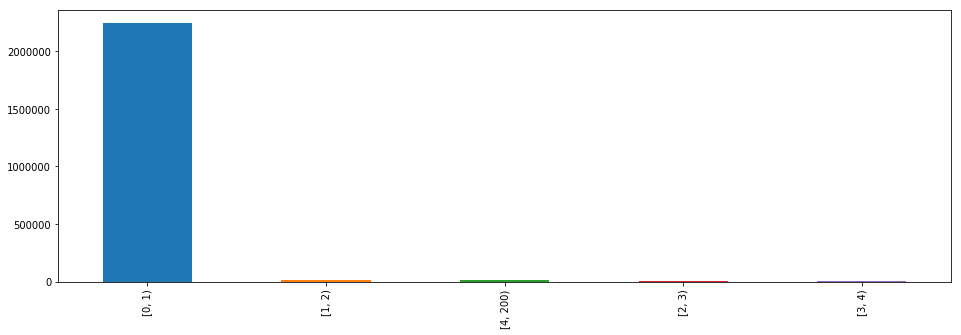

In [12]:
df_train['pay_count_group']=pd.cut( df_train['pay_count'],[0,1,2,3,4,200],right=False)
df_train['pay_count_group'].value_counts().plot.bar(figsize=(16,5));

选取变量描述

In [13]:
df_variable = pd.read_excel('data/tap4fun.xlsx',sheet_name='Sheet1')
df_variable = df_variable.iloc[:,range(3)].rename(columns={'字段名':'column','字段解释':'desc','数据时间':'cycle'})
df_variable['cat'] = df_variable.column.str.split('_').apply(lambda x: x[0])

# df_variable['cat_desc'] = df_variable.desc.str.split('：')#.apply(lambda x:x[0])
df_variable.groupby('cat')['column'].count()


cat
avg            1
bd            16
building       2
cavalry        2
general        2
infantry       2
ivory          2
magic          2
meat           2
pay            2
prediction     1
pve            3
pvp            3
reaserch       2
register       1
shaman         2
sr            49
stone          2
training       2
treatment      2
user           1
wood           2
wound          6
Name: column, dtype: int64

按变量类别查看数据

In [14]:
from toolz.curried import pipe, map, filter, get
import warnings
warnings.filterwarnings('ignore')
sr_var = list(df_variable[df_variable.cat=='sr'].column.values)
df_srdesc = df_train.loc[:,sr_var].sample(frac=.1).describe().transpose()
df_srdesc

,count,mean,std,min,25%,50%,75%,max
sr_scout_level,228801.0,0.331572,0.738572,0.0,0.0,0.0,0.0,7.0
sr_training_speed_level,228801.0,0.300405,0.985558,0.0,0.0,0.0,0.0,16.0
sr_infantry_tier_2_level,228801.0,0.024196,0.153657,0.0,0.0,0.0,0.0,1.0
sr_cavalry_tier_2_level,228801.0,0.023121,0.150287,0.0,0.0,0.0,0.0,1.0
sr_shaman_tier_2_level,228801.0,0.019891,0.139625,0.0,0.0,0.0,0.0,1.0
sr_infantry_atk_level,228801.0,0.023982,0.252950,0.0,0.0,0.0,0.0,9.0
sr_cavalry_atk_level,228801.0,0.022447,0.245027,0.0,0.0,0.0,0.0,8.0
sr_shaman_atk_level,228801.0,0.018260,0.221621,0.0,0.0,0.0,0.0,9.0
sr_infantry_tier_3_level,228801.0,0.000227,0.015074,0.0,0.0,0.0,0.0,1.0
sr_cavalry_tier_3_level,228801.0,0.000214,0.014633,0.0,0.0,0.0,0.0,1.0


数据文件里少一列sr_rss_a_prod_le

In [15]:
df_srdesc = df_srdesc.drop('sr_rss_a_prod_level', axis=0)


合并SR变量组

In [16]:
# df_train[df_train.sr_cavalry_def_level>1]
# df_train['sr_level_score']= df_train.apply(lambda x: x[df_srdesc[df_srdesc['max']==1].index].sum())
cols_sr_level = df_srdesc[df_srdesc['max']==1].index
cols_sr_main = df_srdesc[df_srdesc['max']>1].index

df_train['sr_level_score'] = df_train.filter(cols_sr_level).sum(axis=1)
df_train['sr_main_score']=df_train.filter(cols_sr_main).mean(axis=1)

In [17]:
df_trans =  df_train.drop(df_srdesc.index, axis=1)


df_train['sr_level_score'].describe()

count    2.288007e+06
mean     1.126059e-01
std      5.821053e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.400000e+01
Name: sr_level_score, dtype: float64

In [18]:
print('column# has reduced to %d'%df_trans.shape[1])

column# has reduced to 68


整理bd变量组

In [19]:
bd_var = list(df_variable[df_variable.cat=='bd'].column.values)
bd_srdesc = df_train.loc[:,bd_var].sample(frac=.1).describe().transpose()
bd_srdesc

,count,mean,std,min,25%,50%,75%,max
bd_training_hut_level,228801.0,1.302180,1.972679,0.0,0.0,0.0,2.0,19.0
bd_healing_lodge_level,228801.0,1.021796,1.807430,0.0,0.0,0.0,1.0,19.0
bd_stronghold_level,228801.0,2.085563,2.515235,0.0,0.0,1.0,4.0,21.0
bd_outpost_portal_level,228801.0,1.757418,2.355234,0.0,0.0,0.0,3.0,21.0
bd_barrack_level,228801.0,1.280300,2.030024,0.0,0.0,0.0,1.0,19.0
bd_healing_spring_level,228801.0,0.923519,1.901420,0.0,0.0,0.0,1.0,21.0
bd_dolmen_level,228801.0,0.962155,2.051561,0.0,0.0,0.0,1.0,20.0
bd_guest_cavern_level,228801.0,0.441148,1.625539,0.0,0.0,0.0,0.0,20.0
bd_warehouse_level,228801.0,0.930315,1.955561,0.0,0.0,0.0,1.0,20.0
bd_watchtower_level,228801.0,0.913663,1.888313,0.0,0.0,0.0,1.0,16.0


In [20]:
df_trans['bd_main_score']=df_train.filter(bd_srdesc.index).mean(axis=1)
df_trans = df_trans.drop(bd_srdesc.index, axis=1)
print('reduced column#: %d'%df_trans.shape[1])

reduced column#: 53


整理wood/meat/wound

reduce% = (add - reduce)/add

In [21]:
def merge_add_reduce(cat):
    global df_variable, df_trans, df_train
    vars = df_variable[df_variable.cat==cat].column
    vars_add = pipe(vars, filter(lambda x: x.find('add_')>0),list)
    vars_rdc = pipe(vars, filter(lambda x: x.find('reduce_')>0),list)
    df_trans[cat+'_add']= df_train[vars_add].sum(axis=1)
    df_trans[cat+'_reduce%']= df_train[vars_rdc].sum(axis=1)/df_trans[cat+'_add']
    df_trans.loc[df_trans[cat+'_add']==0,cat+'_reduce%' ] = 0

    try:
        df_trans = df_trans.drop(vars, axis=1)
    except:
        pass
    
cat_set = df_variable[df_variable.column.str.find('reduce')>0].cat.unique()

for cat in cat_set:
    merge_add_reduce(cat)

In [22]:
print('reduced column#: %d'%df_trans.shape[1])
# df_trans[df_trans==np.inf].sum()

reduced column#: 49


合并pve/pvp

新增变量：
- 主动发起比率
- 胜率

In [23]:
vars = df_variable[df_variable.cat=='pve'].column
vars
df_trans['pve_launch%'] = df_train['pve_lanch_count']/df_train['pve_battle_count']
df_trans['pve_win%'] = df_train['pve_win_count']/df_train['pve_battle_count']
df_trans['pvp_launch%'] = df_train['pvp_lanch_count']/df_train['pvp_battle_count']
df_trans['pvp_win%'] = df_train['pvp_win_count']/df_train['pvp_battle_count']

df_trans[['pve_launch%','pve_win%','pvp_launch%','pvp_win%']] = df_trans[['pve_launch%','pve_win%','pvp_launch%','pvp_win%']].fillna(0)
try:
    df_trans =df_trans.drop(['pve_lanch_count','pve_win_count','pvp_lanch_count','pvp_win_count'], axis=1)
except:
    pass
print('reduced column#: %d'%df_trans.shape[1])


reduced column#: 49


计算客单价

In [24]:
df_trans['avg_pay'] = df_trans['pay_price']/df_trans['pay_count']
df_trans.loc[df_trans['pay_count']==0, 'avg_pay'] = 0

有多少比例的用户在7日内付费且7-45继续付费?

In [25]:
cnt_after_7 = df_trans[(df_trans.pay_price>0) & (df_trans.prediction_future_pay_price>0)].shape[0]
cnt_before_7 = df_trans[(df_trans.pay_price>0)].shape[0]
print('{0}% of users will extend payment on next 38 days'.format(cnt_after_7/cnt_before_7*100))

27.290716474818407% of users will extend payment on next 38 days


In [26]:
df_trans[(df_trans.pay_price>0) & (df_trans.prediction_future_pay_price>0)].loc[:,['pay_price','prediction_pay_price','prediction_future_pay_price']].head()

,pay_price,prediction_pay_price,prediction_future_pay_price
40,2.970000,4.960000,1.990000
155,156.880005,166.860001,9.979996
248,14.980000,19.969999,4.990000
381,406.869995,8982.780273,8575.910156
481,6.970000,8.960000,1.990000


test variable correlation and keep high correlated

In [27]:
X = df_trans.drop(labels=['user_id','register_date','prediction_pay_price','register_time','prediction_future_pay_price','pay_price']+
                  list(df_trans.select_dtypes('category').columns), axis=1)
y = df_trans['prediction_future_pay_price']
# df_trans.sample(frac=.1)[df_trans==np.inf].sum()

查看变量间的相关性，按照变量类别从大到小依次排序为：
- bd/building
- pvp
- pve
- wound
- training
- meat
- sr
- shaman


In [28]:

n_var = len(X.columns)
mask = np.zeros((n_var,n_var))
for i in range(n_var):
    for j in range(n_var):
        if i<j:
            mask[i,j]=True
# np.triu(mask)   # equal to upper triangle of array
         

df_corr = (X[X.pay_count>0].sample(frac=.1).corr()>0.8)*mask
df_corr = df_corr.unstack()
df_corr = df_corr[(df_corr==1)]
df_corr= df_corr.to_frame().reset_index().rename(columns={'level_0':'left','level_1':'right'}).iloc[:,:2]
df_corr= df_corr[df_corr.left!=df_corr.right]
df_corr['left_cat'] = df_corr.left.str.split('_').apply(lambda x:x[0])
df_corr['right_cat'] = df_corr.right.str.split('_').apply(lambda x:x[0])
df_corr.groupby(['left_cat','right_cat']).count().transpose()

left_cat  building            general                     ivory      ...   \
right_cat  general ivory wood   ivory meat pay stone wood stone wood ...    
left             1     1    1       1    1   1     1    1     1    1 ...    
right            1     1    1       1    1   1     1    1     1    1 ...    

left_cat  reaserch  shaman stone training                                     
right_cat     wood cavalry  wood  general ivory meat pay reaserch stone wood  
left             1       2     1        1     1    1   1        1     1    1  
right            1       2     1        1     1    1   1        1     1    1  

[2 rows x 30 columns]

数据分布不均匀，归一化并取log使数据接近正态分布

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()

def do_log(x):
    return np.log(x+1)

def do_exp(x):
    return np.exp(x)-1

loger = FunctionTransformer(do_log, do_exp)
pipeline_list = [scaler_X, loger]


根据相关性产生新的特征，消除高相关特征使数据独立分布

In [30]:
#TODO

df_corr
# X_log.isin([np.inf]).sum()

,left,right,left_cat,right_cat
0,stone_add,wood_add,stone,wood
1,ivory_add,wood_add,ivory,wood
2,ivory_add,stone_add,ivory,stone
3,meat_add,wood_add,meat,wood
4,meat_add,stone_add,meat,stone
5,meat_add,ivory_add,meat,ivory
6,meat_reduce%,wood_reduce%,meat,wood
7,shaman_add,cavalry_add,shaman,cavalry
8,shaman_reduce%,cavalry_reduce%,shaman,cavalry
9,general_add,pay_count,general,pay


使用L1范式做特征筛选

In [35]:
from os import cpu_count
from sklearn.linear_model import MultiTaskLassoCV, LassoCV

estimator_lasso= LassoCV(eps=0.001, cv=6, verbose=True, n_jobs=cpu_count())

pipeline_lasso = make_pipeline(scaler_X, loger,estimator_lasso)

pipeline_lasso.fit(X, y)


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:   12.3s finished


Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('functiontransformer', FunctionTransformer(accept_sparse=False,
          func=<function do_log at 0x000000003ECBFD90>, inv_kw_args=None,
          inverse_func=<function do_exp at 0x000000003FDB0510>,
          kw...False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=True))])

test feature importance

In [36]:
var_importance = pipeline_lasso.steps[2][1].coef_
df_variable_importance =pd.DataFrame({'column':X.columns, 'importance':var_importance})
df_variable_importance = pd.merge(df_variable_importance,df_variable,on='column',how='left')
df_variable_importance.sort_values('importance', ascending = False)

,column,importance,desc,cycle,cat
12,ivory_add,294.279306,NaN,NaN,NaN
8,wood_add,206.493702,NaN,NaN,NaN
10,stone_add,120.902012,NaN,NaN,NaN
22,shaman_add,37.089417,NaN,NaN,NaN
40,avg_pay,31.014522,NaN,NaN,NaN
9,wood_reduce%,22.229897,NaN,NaN,NaN
20,cavalry_add,17.289842,NaN,NaN,NaN
21,cavalry_reduce%,11.825961,NaN,NaN,NaN
6,sr_main_score,11.628810,NaN,NaN,NaN
17,magic_reduce%,10.639985,NaN,NaN,NaN


evaluate model using MAE

In [40]:
y_predict = pipeline_lasso.predict(X)
pipeline_lasso.score(X, y)

0.17473207218345499

In [109]:
y_predict[:4]

array([-0.93381757, -0.99450619, -1.05097127, -1.18031463])

run SGD Classifier to predict if user will pay in future, using most import varaible

In [52]:
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
X_classfier = X#.loc[:,df_variable_importance.column] #'pay_price','pay_count','avg_pay' df_variable_importance.column
y_classfier = y >0
X_train, X_test, y_train, y_test =train_test_split(X_classfier, y_classfier, test_size=0.3)

In [56]:
%%time
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import scale

md_sgd = SGDClassifier(loss = 'hinge',fit_intercept=True, penalty='l2',learning_rate='optimal',eta0=0.01, max_iter=50)#,class_weight={False:2,True:1})

pipeline_classfier = make_pipeline(scaler_X,md_sgd)
pipeline_classfier.fit(X_train,y_train)

Wall time: 27.2 s


In [57]:
from sklearn.metrics import f1_score
y_predict = pipeline_classfier.predict(X_train)
f1_score(y_predict, y_train)


0.18784739767559372

In [93]:
y_train.sum(),y_predict.sum()
SGDClassifier?

(10622, 5762)

test importance using Random Forest

test importance using XGBClassifier

In [65]:
# from xgboost import XGBRegressor  # change import
from dask_ml.xgboost import XGBClassifier
from dask.distributed import Client
client = Client()
est = XGBClassifier()
est.fit(ddf.from_pandas(X_train,npartitions=8), ddf.from_pandas(y_train,npartitions=8))

y_predict = est.predict(ddf.from_pandas(X_train,npartitions=8))
f1_score(y_predict, y_train)

0.013780479638076387